Author: Chris J. Dallmann \
Affiliation: University of Wuerzburg \
Last revision: 11-March-2025

In [1]:
from caveclient import CAVEclient
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

In [2]:
# IDs of GABAergic neurons presynaptic to claw and hook
dict_target_ids = dict()
dict_target_ids['13B_claw'] = [648518346484847261] 
dict_target_ids['19A_claw'] = [648518346531401754, 648518346472653065, 648518346488555913, 648518346498429489,
                               648518346502916595, 648518346488659278, 648518346521506809, 648518346518741215,
                               648518346465091957, 648518346494217863, 648518346499593822, 648518346501344355,
                               648518346491096865]
dict_target_ids['Chief_9A_hook'] = [648518346496946148]
dict_target_ids['Other_9A_hook'] = [648518346479847574, 648518346479837078, 648518346498002535, 648518346479879156,
                                    648518346467364359, 648518346486716621]
dict_target_ids['13B_hook'] = [648518346502572199]
dict_target_ids['19A_hook'] = [648518346479427282, 648518346494008718]

target_ids = list(dict_target_ids.values())
target_ids = [item for i in target_ids for item in i]

In [3]:
# # Option 1: Load pre-computed connectivity dataframe
# df_connectivity = pd.read_csv('../data/fanc_dn_in_connectivity.csv')

In [4]:
# Option 2: Build connectivity dataframe from scratch via CAVEclient

# Initialize CAVEclient
# This step requires an authentication token, see https://caveclient.readthedocs.io/en/latest/guide/authentication.html
client = CAVEclient()
datastack_name = 'fanc_production_mar2021'
client = CAVEclient(datastack_name)
client.materialize.version = 840

# Query input synapses
df_connectivity = client.materialize.synapse_query(post_ids=target_ids)

# Remove connections less than syn_thresh  
syn_thresh = 3;
df_connectivity['syn_count'] = 1
df_connectivity = df_connectivity.groupby(['pre_pt_root_id','post_pt_root_id'])['syn_count'].sum().reset_index().sort_values('syn_count', ascending=False)
df_connectivity = df_connectivity[df_connectivity.syn_count>=syn_thresh]

# Get neuron information
df_neuron_info = client.materialize.query_table('neuron_information')

# Get IDs of source neurons
source_ids = df_neuron_info.pt_root_id[df_neuron_info.tag == 'descending'].tolist()

# Remove connections with neurons other than source neurons
df_connectivity = df_connectivity[df_connectivity['pre_pt_root_id'].isin(source_ids)]

# # Save df_connectivity
# df_connectivity.to_csv('../data/fanc_dn_in_connectivity.csv')

In [5]:
# Compute connectivity matrix 
pre_ids = df_connectivity.pre_pt_root_id.unique().tolist()
post_ids = df_connectivity.post_pt_root_id.unique().tolist()

connectivity_matrix = np.zeros((len(pre_ids),len(post_ids)))
for pre_index, pre_id in enumerate(pre_ids):
    df = df_connectivity[df_connectivity.pre_pt_root_id == pre_id]
    for index, row in df.iterrows():
        post_index = post_ids.index(row.post_pt_root_id)
        syn_count = row.syn_count
        connectivity_matrix[pre_index, post_index] += syn_count

In [6]:
# Sort connectivity matrix and IDs

# Sort columns of connectivity matrix and post_ids
sort_index = []
for target_id in target_ids:
    if target_id in post_ids:
        sort_index.append(post_ids.index(target_id))   

connectivity_matrix = connectivity_matrix[:,sort_index]
post_ids = [post_ids[index] for index in sort_index]

# Sort rows of connectivity matrix and pre_ids
sort_index_list = []
for index, pre_id in enumerate(pre_ids):
    # Get first column index where connectivity_matrix>0
    first_index = next(x[0] for x in enumerate(connectivity_matrix[index,:]) if x[1] > 0)
    sort_index_list.append([index, first_index])

sort_index_list = sorted(sort_index_list, key = lambda x: (x[1]), reverse = False)
sort_index = [index[0] for index in sort_index_list]

connectivity_matrix = connectivity_matrix[sort_index,:]
pre_ids = [pre_ids[i] for i in sort_index]

In [7]:
# Load information about descending neurons 
# Based on matched neurons in MANC (Stürner et al. 2024, https://doi.org/10.1101/2024.06.04.596633) 
# Name is provided for known walking and grooming neurons
df_dn_info = pd.read_csv('../data/fanc_dn_information.csv')

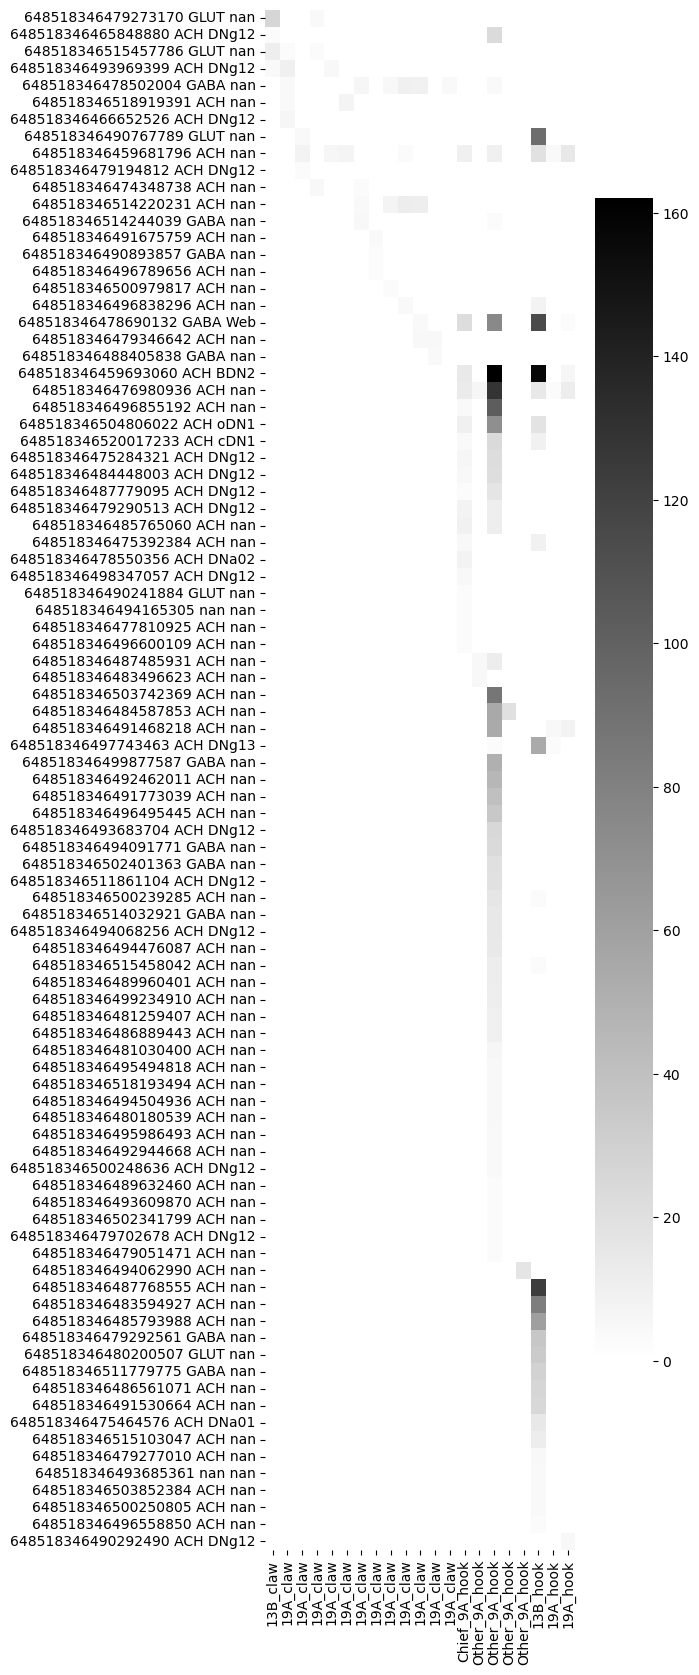

In [8]:
# Plot connectivity matrix
fig = plt.figure(figsize=(5,20))
cmap = sns.color_palette("gray_r", as_cmap=True)

yticklabels = []
for pre_id in pre_ids:
    nt_type = df_dn_info.nt_type[df_dn_info.pt_root_id == pre_id].item()
    name = df_dn_info.name[df_dn_info.pt_root_id == pre_id].item()
    if pd.isnull(nt_type):
        nt_type = 'nan'

    if pd.isnull(name):
        name = 'nan'
        
    yticklabels.append(str(pre_id) + ' ' + nt_type + ' ' + name)

xticklabels = []
for post_id in post_ids:
    xticklabels.append([k for k, v in dict_target_ids.items() if post_id in v][0])

sns.heatmap(connectivity_matrix, 
            cmap=cmap, 
            xticklabels=xticklabels, 
            yticklabels=yticklabels)
plt.show()

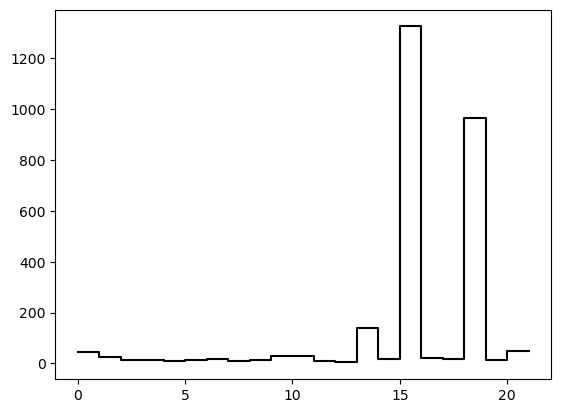

In [9]:
# Plot distribution of synapses
# For columns, set axis=0
# For rows, set axis=1
n_syn = np.sum(connectivity_matrix, axis=0)
plt.step(range(len(n_syn)+1), np.insert(n_syn, 0, n_syn[0]), color=[0,0,0]) # For step function, duplicate first value
plt.show()

In [10]:
# Build connectivity matrix for descending neuron to 9A neuron connectivity 
pre_names = ['BDN2','oDN1','cDN1','DNa02','DNg12','Other_ACH','Web','Other_GABA','Other_GLUT','Other_unknown']
post_id_index = [13,14,15,16,17] # Chief 9A, other 9As
connectivity_matrix_9A = np.zeros((len(pre_names),len(post_id_index)))

for pre_id_index, pre_id in enumerate(pre_ids):
    n_syn = connectivity_matrix[pre_id_index,post_id_index]
    if np.sum(n_syn)>0:
        nt_type = df_dn_info.nt_type[df_dn_info['pt_root_id'] == pre_id].item()
        name = df_dn_info.name[df_dn_info['pt_root_id'] == pre_id].item()
        
        if name not in pre_names:
            if nt_type == 'ACH':
                name = 'Other_ACH'
            elif nt_type == 'GABA':
                name = 'Other_GABA'
            elif nt_type == 'GLUT':
                name = 'Other_GLUT'
            else:
                name = 'Other_unknown'

        pre_index = pre_names.index(name)
        connectivity_matrix_9A[pre_index,:] += n_syn  

In [11]:
# Normalize connectivity matrix by total number of input synapses 
n_syn_9A = [202, 131, 4017, 224, 459] 
normalized_connectivity_matrix_9A = connectivity_matrix_9A/n_syn_9A*100

# # Query total number of input synapses via CAVEclient
# # Chief 9A: 648518346496946148
# # Other 9A: 648518346479847574
# # Other 9A: 648518346479837078
# # Other 9A: 648518346479879156
# # Other 9A: 648518346467364359
# df = client.materialize.synapse_query(post_ids=648518346467364359)
# df['syn_count'] = 1
# syn_thresh = 3;
# df = df.groupby(['pre_pt_root_id','post_pt_root_id'])['syn_count'].sum().reset_index().sort_values('syn_count', ascending=False)
# df = df[df.syn_count>=syn_thresh]
# print(df.syn_count.sum())

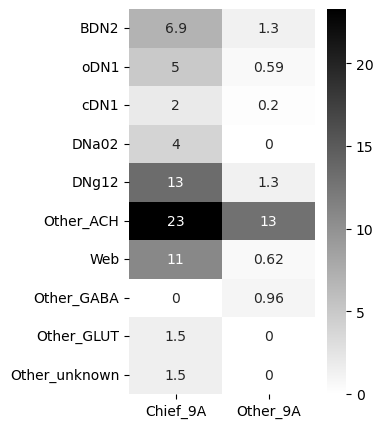

In [12]:
# Plot connectivity matrix 
# Merge 'Other_9A' 

# Percent synapses
matrix_to_plot = np.zeros((np.size(normalized_connectivity_matrix_9A, axis=0), 2))
matrix_to_plot[:,0] = normalized_connectivity_matrix_9A[:,0]
matrix_to_plot[:,1] = np.mean(normalized_connectivity_matrix_9A[:,1:4], axis=1) 

# # Absolute synapses
# matrix_to_plot = np.zeros((np.size(connectivity_matrix_9A,axis=0), 2))
# matrix_to_plot[:,0] = connectivity_matrix_9A[:,0]
# matrix_to_plot[:,1] = np.sum(connectivity_matrix_9A[:,1:4],axis=1) 

xticklabels = ['Chief_9A','Other_9A']
yticklabels = pre_names

fig = plt.figure(figsize=(3,5))
cmap = sns.color_palette("gray_r", as_cmap=True)
sns.heatmap(matrix_to_plot, 
            cmap=cmap, 
            xticklabels=xticklabels, 
            yticklabels=yticklabels,
            annot=True)
plt.show()

In [13]:
# # Query predicted neurotransmitter for specific neuron(s) in MANC
# from neuprint import Client
# from neuprint import NeuronCriteria as NC
# from neuprint import fetch_neurons

# # Initialize client
# token = ''
# c = Client('neuprint.janelia.org', dataset='manc:v1.0', token=token)
# c.fetch_version()

# manc_ids = []
# criteria = NC(bodyId=manc_ids)
# neuron_df, _ = fetch_neurons(criteria)
# print(neuron_df.predictedNt.item())

# # Loop through matched descending neurons in MANC
# df_fanc_to_manc = pd.read_csv('...')
# manc_ids, manc_names, nt_type = [], [], []
# for pre_id in pre_ids:
#     manc_id = df_fanc_to_manc.manc_match_id[df_fanc_to_manc.root_id == pre_id].item()
#     manc_name = df_fanc_to_manc.type[df_fanc_to_manc.root_id == pre_id].item()
#     if pd.isnull(manc_id):
#         nt_type.append('nan')
#         manc_ids.append('nan')
#         manc_names.append('nan')
#     else:
#         manc_id = int(manc_id)
#         criteria = NC(bodyId=[manc_id])
#         neuron_df, _ = fetch_neurons(criteria)
#         nt_type.append(neuron_df.predictedNt.item())
#         manc_ids.append(manc_id)
#         manc_names.append(manc_name)